<a href="https://colab.research.google.com/github/Sriramlingavel/MultiModal_Fashion_LLM/blob/main/paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# Replace 'your_file.zip' with the name of the uploaded zip file
with zipfile.ZipFile('/content/drive/MyDrive/paligemma_model.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Files')

In [ ]:
# Step 1: Install required libraries
!pip install -q huggingface_hub transformers

# Step 2: Login to Hugging Face (run this cell and paste your token)
from huggingface_hub import login

# Paste your token when prompted
login()

# Step 3: Download all model files
from huggingface_hub import snapshot_download

local_dir = snapshot_download(
    repo_id="google/paligemma-3b-pt-224",
    local_dir="./paligemma_model",
    local_dir_use_symlinks=False  # Make it portable and zip-friendly
)

print(f"Model downloaded to {local_dir}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Model downloaded to /content/paligemma_model


In [ ]:
import os
import zipfile
from tqdm import tqdm

source_dir = "/content/paligemma_model"
zip_path = "/content/drive/MyDrive/paligemma_model.zip"

# Collect all file paths
file_paths = []
for root, _, files in os.walk(source_dir):
    for file in files:
        full_path = os.path.join(root, file)
        rel_path = os.path.relpath(full_path, source_dir)
        file_paths.append((full_path, rel_path))

# Zip with tqdm progress bar
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for full_path, rel_path in tqdm(file_paths, desc="Zipping files", unit="file"):
        zipf.write(full_path, arcname=rel_path)

print(f"✅ Done! Zipped to: {zip_path}")


Zipping files: 100%|██████████| 43/43 [15:20<00:00, 21.42s/file]

✅ Done! Zipped to: /content/drive/MyDrive/paligemma_model.zip


# PALIGEMMA ARCHITECTURE (working code)

In [ ]:
!pip install sympy==1.12.0 fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 60.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d124d19cb824e3fac77774dc44edcf71341c48166f8505c4e8e9f34d05644a89
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu12

In [ ]:
# === modeling_siglip.py ===
from typing import Optional, Tuple
import torch
import torch.nn as nn

class SiglipVisionConfig:

    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_dropout=0.0,
        num_image_tokens: int = None,
        **kwargs
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.image_size = image_size
        self.attention_dropout = attention_dropout
        self.layer_norm_eps = layer_norm_eps
        self.num_image_tokens = num_image_tokens


class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", # This indicates no padding is added
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False,
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        _, _, height, width = pixel_values.shape # [Batch_Size, Channels, Height, Width]
        # Convolve the `patch_size` kernel over the image, with no overlapping patches since the stride is equal to the kernel size
        # The output of the convolution will have shape [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W]
        # where Num_Patches_H = height // patch_size and Num_Patches_W = width // patch_size
        patch_embeds = self.patch_embedding(pixel_values)
        # [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W] -> [Batch_Size, Embed_Dim, Num_Patches]
        # where Num_Patches = Num_Patches_H * Num_Patches_W
        embeddings = patch_embeds.flatten(2)
        # [Batch_Size, Embed_Dim, Num_Patches] -> [Batch_Size, Num_Patches, Embed_Dim]
        embeddings = embeddings.transpose(1, 2)
        # Add position embeddings to each patch. Each positional encoding is a vector of size [Embed_Dim]
        embeddings = embeddings + self.position_embedding(self.position_ids)
        # [Batch_Size, Num_Patches, Embed_Dim]
        return embeddings


class SiglipAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5 # Equivalent to 1 / sqrt(self.head_dim)
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        # hidden_states: [Batch_Size, Num_Patches, Embed_Dim]
        batch_size, seq_len, _ = hidden_states.size()
        # query_states: [Batch_Size, Num_Patches, Embed_Dim]
        query_states = self.q_proj(hidden_states)
        # key_states: [Batch_Size, Num_Patches, Embed_Dim]
        key_states = self.k_proj(hidden_states)
        # value_states: [Batch_Size, Num_Patches, Embed_Dim]
        value_states = self.v_proj(hidden_states)
        # query_states: [Batch_Size, Num_Heads, Num_Patches, Head_Dim]
        query_states = query_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        key_states = key_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        value_states = value_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Calculate the attention using the formula Q * K^T / sqrt(d_k). attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = (torch.matmul(query_states, key_states.transpose(2, 3)) * self.scale)

        if attn_weights.size() != (batch_size, self.num_heads, seq_len, seq_len):
            raise ValueError(
                f"Attention weights should be of size {(batch_size, self.num_heads, seq_len, seq_len)}, but is"
                f" {attn_weights.size()}"
            )

        # Apply the softmax row-wise. attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Apply dropout only during training
        attn_weights = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)
        # Multiply the attention weights by the value states. attn_output: [Batch_Size, Num_Heads, Num_Patches, Head_Dim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (batch_size, self.num_heads, seq_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, seq_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        # [Batch_Size, Num_Heads, Num_Patches, Head_Dim] -> [Batch_Size, Num_Patches, Num_Heads, Head_Dim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # [Batch_Size, Num_Patches, Num_Heads, Head_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        # [Batch_Size, Num_Patches, Embed_Dim]
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class SiglipMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = self.fc1(hidden_states)
        # hidden_states: [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        # [Batch_Size, Num_Patches, Intermediate_Size] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.fc2(hidden_states)

        return hidden_states


class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    # Ignore copy
    def forward(
        self,
        hidden_states: torch.Tensor
    ) -> torch.Tensor:
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm1(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states, _ = self.self_attn(hidden_states=hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm2(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states

        return hidden_states


class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    # Ignore copy
    def forward(
        self,
        inputs_embeds: torch.Tensor
    ) -> torch.Tensor:
        # inputs_embeds: [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = inputs_embeds

        for encoder_layer in self.layers:
            # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
            hidden_states = encoder_layer(hidden_states)

        return hidden_states


class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # pixel_values: [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.embeddings(pixel_values)

        last_hidden_state = self.encoder(inputs_embeds=hidden_states)

        last_hidden_state = self.post_layernorm(last_hidden_state)

        return last_hidden_state


class SiglipVisionModel(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values) -> Tuple:
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        return self.vision_model(pixel_values=pixel_values)


# === modeling_gemma.py ===
import torch
from torch import nn
from typing import Optional, Tuple, List
from torch.nn import CrossEntropyLoss
import math


class KVCache():

    def __init__(self) -> None:
        self.key_cache: List[torch.Tensor] = []
        self.value_cache: List[torch.Tensor] = []

    def num_items(self) -> int:
        if len(self.key_cache) == 0:
            return 0
        else:
            # The shape of the key_cache is [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
            return self.key_cache[0].shape[-2]

    def update(
        self,
        key_states: torch.Tensor,
        value_states: torch.Tensor,
        layer_idx: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if len(self.key_cache) <= layer_idx:
            # If we never added anything to the KV-Cache of this layer, let's create it.
            self.key_cache.append(key_states)
            self.value_cache.append(value_states)
        else:
            # ... otherwise we concatenate the new keys with the existing ones.
            # each tensor has shape: [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
            self.key_cache[layer_idx] = torch.cat([self.key_cache[layer_idx], key_states], dim=-2)
            self.value_cache[layer_idx] = torch.cat([self.value_cache[layer_idx], value_states], dim=-2)

        # ... and then we return all the existing keys + the new ones.
        return self.key_cache[layer_idx], self.value_cache[layer_idx]

class GemmaConfig():

    def __init__(
        self,
        vocab_size,
        hidden_size,
        intermediate_size,
        num_hidden_layers,
        num_attention_heads,
        num_key_value_heads,
        head_dim=256,
        max_position_embeddings=8192,
        rms_norm_eps=1e-6,
        rope_theta=10000.0,
        attention_bias=False,
        attention_dropout=0.0,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.head_dim = head_dim
        self.num_key_value_heads = num_key_value_heads
        self.rms_norm_eps = rms_norm_eps
        self.rope_theta = rope_theta
        self.attention_bias = attention_bias
        self.attention_dropout = attention_dropout
        self.pad_token_id = pad_token_id

class PaliGemmaConfig():

    def __init__(
        self,
        vision_config=None,
        text_config=None,
        ignore_index=-100,
        image_token_index=256000,
        vocab_size=257152,
        projection_dim=2048,
        hidden_size=2048,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.ignore_index = ignore_index
        self.image_token_index = image_token_index
        self.vocab_size = vocab_size
        self.projection_dim = projection_dim
        self.hidden_size = hidden_size
        self.vision_config = vision_config
        self.is_encoder_decoder = False
        self.pad_token_id = pad_token_id

        self.vision_config = SiglipVisionConfig(**vision_config)
        self.text_config = text_config

        self.text_config = GemmaConfig(**text_config, pad_token_id=pad_token_id)
        self.vocab_size = self.text_config.vocab_size

        self.text_config.num_image_tokens = (self.vision_config.image_size // self.vision_config.patch_size) ** 2
        self.vision_config.projection_dim = projection_dim


class GemmaRMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float())
        # Llama does x.to(float16) * w whilst Gemma is (x * w).to(float16)
        # See https://github.com/huggingface/transformers/pull/29402
        output = output * (1.0 + self.weight.float())
        return output.type_as(x)

class GemmaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim # it is set to the head_dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base

        # Calculate the theta according to the formula theta_i = base^(-2i/dim) where i = 0, 1, 2, ..., dim // 2
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim))
        self.register_buffer("inv_freq", tensor=inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        self.inv_freq.to(x.device)
        # Copy the inv_freq tensor for batch in the sequence
        # inv_freq_expanded: [Batch_Size, Head_Dim // 2, 1]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        # position_ids_expanded: [Batch_Size, 1, Seq_Len]
        position_ids_expanded = position_ids[:, None, :].float()
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            # Multiply each theta by the position (which is the argument of the sin and cos functions)
            # freqs: [Batch_Size, Head_Dim // 2, 1] @ [Batch_Size, 1, Seq_Len] --> [Batch_Size, Seq_Len, Head_Dim // 2]
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            # emb: [Batch_Size, Seq_Len, Head_Dim]
            emb = torch.cat((freqs, freqs), dim=-1)
            # cos, sin: [Batch_Size, Seq_Len, Head_Dim]
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


def rotate_half(x):
    # Build the [-x2, x1, -x4, x3, ...] tensor for the sin part of the positional encoding.
    x1 = x[..., : x.shape[-1] // 2] # Takes the first half of the last dimension
    x2 = x[..., x.shape[-1] // 2 :] # Takes the second half of the last dimension
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim) # Add the head dimension
    sin = sin.unsqueeze(unsqueeze_dim) # Add the head dimension
    # Apply the formula (34) of the Rotary Positional Encoding paper.
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class GemmaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

    def forward(self, x):
        # Equivalent to:
        # y = self.gate_proj(x) # [Batch_Size, Seq_Len, Hidden_Size] -> [Batch_Size, Seq_Len, Intermediate_Size]
        # y = torch.gelu(y, approximate="tanh") # [Batch_Size, Seq_Len, Intermediate_Size]
        # j = self.up_proj(x) # [Batch_Size, Seq_Len, Hidden_Size] -> [Batch_Size, Seq_Len, Intermediate_Size]
        # z = y * j # [Batch_Size, Seq_Len, Intermediate_Size]
        # z = self.down_proj(z) # [Batch_Size, Seq_Len, Intermediate_Size] -> [Batch_Size, Seq_Len, Hidden_Size]
        return self.down_proj(nn.functional.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x))

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

class GemmaAttention(nn.Module):

    def __init__(self, config: GemmaConfig, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = config.head_dim
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta
        self.is_causal = True

        assert self.hidden_size % self.num_heads == 0

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=config.attention_bias)
        self.rotary_emb = GemmaRotaryEmbedding(
            self.head_dim,
            max_position_embeddings=self.max_position_embeddings,
            base=self.rope_theta,
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        kv_cache: Optional[KVCache] = None,
        **kwargs,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size() # [Batch_Size, Seq_Len, Hidden_Size]
        # [Batch_Size, Seq_Len, Num_Heads_Q * Head_Dim]
        query_states = self.q_proj(hidden_states)
        # [Batch_Size, Seq_Len, Num_Heads_KV * Head_Dim]
        key_states = self.k_proj(hidden_states)
        # [Batch_Size, Seq_Len, Num_Heads_KV * Head_Dim]
        value_states = self.v_proj(hidden_states)
        # [Batch_Size, Num_Heads_Q, Seq_Len, Head_Dim]
        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        # [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        # [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        # [Batch_Size, Seq_Len, Head_Dim], [Batch_Size, Seq_Len, Head_Dim]
        cos, sin = self.rotary_emb(value_states, position_ids, seq_len=None)
        # [Batch_Size, Num_Heads_Q, Seq_Len, Head_Dim], [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if kv_cache is not None:
            key_states, value_states = kv_cache.update(key_states, value_states, self.layer_idx)

        # Repeat the key and values to match the number of heads of the query
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)
        # Perform the calculation as usual, Q * K^T / sqrt(head_dim). Shape: [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV]
        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        assert attention_mask is not None
        attn_weights = attn_weights + attention_mask

        # Apply the softmax
        # [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Apply the dropout
        attn_weights = nn.functional.dropout(attn_weights, p=self.attention_dropout, training=self.training)
        # Multiply by the values. [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV] x [Batch_Size, Num_Heads_KV, Seq_Len_KV, Head_Dim] -> [Batch_Size, Num_Heads_Q, Seq_Len_Q, Head_Dim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        # Make sure the sequence length is the second dimension. # [Batch_Size, Num_Heads_Q, Seq_Len_Q, Head_Dim] -> [Batch_Size, Seq_Len_Q, Num_Heads_Q, Head_Dim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # Concatenate all the heads together. [Batch_Size, Seq_Len_Q, Num_Heads_Q, Head_Dim] -> [Batch_Size, Seq_Len_Q, Num_Heads_Q * Head_Dim]
        attn_output = attn_output.view(bsz, q_len, -1)
        # Multiply by W_o. [Batch_Size, Seq_Len_Q, Hidden_Size]
        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights

class GemmaDecoderLayer(nn.Module):

    def __init__(self, config: GemmaConfig, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.self_attn = GemmaAttention(config=config, layer_idx=layer_idx)

        self.mlp = GemmaMLP(config)
        self.input_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        residual = hidden_states
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.input_layernorm(hidden_states)

        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states, _, = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            kv_cache=kv_cache,
        )
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = residual + hidden_states

        # [Batch_Size, Seq_Len, Hidden_Size]
        residual = hidden_states
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.post_attention_layernorm(hidden_states)
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = residual + hidden_states

        return hidden_states

class GemmaModel(nn.Module):

    def __init__(self, config: GemmaConfig):
        super().__init__()
        self.config = config
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)
        self.layers = nn.ModuleList(
            [GemmaDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self.norm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def get_input_embeddings(self):
        return self.embed_tokens

    # Ignore copy
    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> torch.FloatTensor:
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = inputs_embeds
        # [Batch_Size, Seq_Len, Hidden_Size]
        normalizer = torch.tensor(self.config.hidden_size**0.5, dtype=hidden_states.dtype)
        hidden_states = hidden_states * normalizer

        for decoder_layer in self.layers:
            # [Batch_Size, Seq_Len, Hidden_Size]
            hidden_states = decoder_layer(
                hidden_states,
                attention_mask=attention_mask,
                position_ids=position_ids,
                kv_cache=kv_cache,
            )

        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.norm(hidden_states)

        # [Batch_Size, Seq_Len, Hidden_Size]
        return hidden_states

class GemmaForCausalLM(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = GemmaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def tie_weights(self):
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple:

        # input_embeds: [Batch_Size, Seq_Len, Hidden_Size]
        # outputs: [Batch_Size, Seq_Len, Hidden_Size]
        outputs = self.model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            kv_cache=kv_cache,
        )

        hidden_states = outputs
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        return_data = {
            "logits": logits,
        }

        if kv_cache is not None:
            # Return the updated cache
            return_data["kv_cache"] = kv_cache

        return return_data

class PaliGemmaMultiModalProjector(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.linear = nn.Linear(config.vision_config.hidden_size, config.vision_config.projection_dim, bias=True)

    def forward(self, image_features):
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Projection_Dim]
        hidden_states = self.linear(image_features)
        return hidden_states

class PaliGemmaForConditionalGeneration(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.config = config
        self.vision_tower = SiglipVisionModel(config.vision_config)
        self.multi_modal_projector = PaliGemmaMultiModalProjector(config)
        self.vocab_size = config.vocab_size

        language_model = GemmaForCausalLM(config.text_config)
        self.language_model = language_model

        self.pad_token_id = self.config.pad_token_id if self.config.pad_token_id is not None else -1

    def tie_weights(self):
        return self.language_model.tie_weights()

    def _merge_input_ids_with_image_features(self, image_features: torch.Tensor, inputs_embeds: torch.Tensor, input_ids: torch.Tensor, attention_mask: torch.Tensor, kv_cache: Optional[KVCache] = None):
        batch_size, num_patches, embed_dim = image_features.shape
        batch_size_input, sequence_length = input_ids.shape
        dtype, device = inputs_embeds.dtype, inputs_embeds.device

        # Shape: [Batch_Size, Seq_Len, Hidden_Size]
        scaled_image_features = image_features / (self.config.hidden_size**0.5)

        # Combine the embeddings of the image tokens, the text tokens and mask out all the padding tokens.
        final_embedding = torch.zeros(batch_size, sequence_length, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device)

        # Shape: [Batch_Size, Seq_Len]. True for text tokens
        text_mask = (input_ids != self.config.image_token_index) & (input_ids != self.pad_token_id)

        # Shape: [Batch_Size, Seq_Len]. True for image tokens
        image_mask = input_ids == self.config.image_token_index

        # Shape: [Batch_Size, Seq_Len]. True for padding tokens
        pad_mask = input_ids == self.pad_token_id

        # We need to expand the masks to the embedding dimension otherwise we can't use them in torch.where
        text_mask_expanded = text_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        pad_mask_expanded = pad_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        image_mask_expanded = image_mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        # Add the text embeddings
        final_embedding = torch.where(text_mask_expanded, inputs_embeds, final_embedding)

        # FIX: Count the number of image tokens per batch item and ensure we have enough features
        for batch_idx in range(batch_size):
            image_token_positions = torch.where(image_mask[batch_idx])[0]
            num_image_tokens = len(image_token_positions)

            # Make sure we don't try to insert more features than we have
            if num_image_tokens > 0:
                # If we have more image tokens than features, we need to repeat the features
                # or use a subset of the tokens depending on requirements
                features_to_use = scaled_image_features[batch_idx, :num_image_tokens]

                # Insert image embeddings for each image token position
                for token_idx, pos in enumerate(image_token_positions):
                    if token_idx < len(features_to_use):
                        final_embedding[batch_idx, pos] = features_to_use[token_idx]

        # Zero out padding tokens
        final_embedding = torch.where(pad_mask_expanded, torch.zeros_like(final_embedding), final_embedding)

        #### CREATE THE ATTENTION MASK ####

        dtype, device = inputs_embeds.dtype, inputs_embeds.device
        min_dtype = torch.finfo(dtype).min
        q_len = inputs_embeds.shape[1]

        if kv_cache is None or kv_cache.num_items() == 0:
            # Do not mask any token, because we're in the prefill phase
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, q_len), fill_value=0, dtype=dtype, device=device
            )
        else:
            # Since we are generating tokens, the query must be one single token
            assert q_len == 1
            kv_len = kv_cache.num_items() + q_len
            # Also in this case we don't need to mask anything, since each query should be able to attend all previous tokens.
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, kv_len), fill_value=0, dtype=dtype, device=device
            )

        # Add the head dimension
        # [Batch_Size, Q_Len, KV_Len] -> [Batch_Size, Num_Heads_Q, Q_Len, KV_Len]
        causal_mask = causal_mask.unsqueeze(1)

        if kv_cache is not None and kv_cache.num_items() > 0:
            # The position of the query is just the last position
            position_ids = attention_mask.cumsum(-1)[:, -1]
            if position_ids.dim() == 1:
                position_ids = position_ids.unsqueeze(0)
        else:
            # Create a position_ids based on the size of the attention_mask
            # For masked tokens, use the number 1 as position.
            position_ids = (attention_mask.cumsum(-1)).masked_fill_((attention_mask == 0), 1).to(device)

        return final_embedding, causal_mask, position_ids

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: torch.FloatTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple:

        # Make sure the input is right-padded
        #assert torch.all(attention_mask == 1), "The input cannot be padded"

        # 1. Extra the input embeddings
        # shape: (Batch_Size, Seq_Len, Hidden_Size)
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

        # 2. Merge text and images
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        selected_image_feature = self.vision_tower(pixel_values.to(inputs_embeds.dtype))
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Hidden_Size]
        image_features = self.multi_modal_projector(selected_image_feature)

        # Merge the embeddings of the text tokens and the image tokens
        inputs_embeds, attention_mask, position_ids = self._merge_input_ids_with_image_features(image_features, inputs_embeds, input_ids, attention_mask, kv_cache)

        outputs = self.language_model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            kv_cache=kv_cache,
        )

        return outputs


# === utils.py ===
from transformers import AutoTokenizer
import json
import glob
from safetensors import safe_open
from typing import Tuple
import os

def load_hf_model(model_path: str, device: str) -> Tuple[PaliGemmaForConditionalGeneration, AutoTokenizer]:
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="right")
    assert tokenizer.padding_side == "right"

    # Find all the *.safetensors files
    safetensors_files = glob.glob(os.path.join(model_path, "*.safetensors"))

    # ... and load them one by one in the tensors dictionary
    tensors = {}
    for safetensors_file in safetensors_files:
        with safe_open(safetensors_file, framework="pt", device="cpu") as f:
            for key in f.keys():
                tensors[key] = f.get_tensor(key)

    # Load the model's config
    with open(os.path.join(model_path, "config.json"), "r") as f:
        model_config_file = json.load(f)
        config = PaliGemmaConfig(**model_config_file)

    # Create the model using the configuration
    model = PaliGemmaForConditionalGeneration(config).to(device)

    # Load the state dict of the model
    model.load_state_dict(tensors, strict=False)

    # Tie weights
    model.tie_weights()

    return (model, tokenizer)

# === processing_paligemma.py ===
from typing import Dict, List, Optional, Union, Tuple, Iterable
import numpy as np
from PIL import Image
import torch

IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]


def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    # Quoting from the blog (https://huggingface.co/blog/paligemma#detailed-inference-process):
    #   The input text is tokenized normally.
    #   A <bos> token is added at the beginning, and an additional newline token (\n) is appended.
    #   This newline token is an essential part of the input prompt the model was trained with, so adding it explicitly ensures it's always there.
    #   The tokenized text is also prefixed with a fixed number of <image> tokens.
    # NOTE: from the paper it looks like the `\n` should be tokenized separately, but in the HF implementation this is not done.
    #       ref to HF implementation: https://github.com/huggingface/transformers/blob/7f79a97399bb52aad8460e1da2f36577d5dccfed/src/transformers/models/paligemma/processing_paligemma.py#L55-L73
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"


def rescale(
    image: np.ndarray, scale: float, dtype: np.dtype = np.float32
) -> np.ndarray:
    rescaled_image = image * scale
    rescaled_image = rescaled_image.astype(dtype)
    return rescaled_image


def resize(
    image: Image,
    size: Tuple[int, int],
    resample: Image.Resampling = None,
    reducing_gap: Optional[int] = None,
) -> np.ndarray:
    height, width = size
    resized_image = image.resize(
        (width, height), resample=resample, reducing_gap=reducing_gap
    )
    return resized_image


def normalize(
    image: np.ndarray,
    mean: Union[float, Iterable[float]],
    std: Union[float, Iterable[float]],
) -> np.ndarray:
    mean = np.array(mean, dtype=image.dtype)
    std = np.array(std, dtype=image.dtype)
    image = (image - mean) / std
    return image


def process_images(
    images: List[Image.Image],
    size: Dict[str, int] = None,
    resample: Image.Resampling = None,
    rescale_factor: float = None,
    image_mean: Optional[Union[float, List[float]]] = None,
    image_std: Optional[Union[float, List[float]]] = None,
) -> List[np.ndarray]:
    height, width = size[0], size[1]
    images = [
        resize(image=image, size=(height, width), resample=resample) for image in images
    ]
    # Convert each image to a numpy array
    images = [np.array(image) for image in images]
    # Rescale the pixel values to be in the range [0, 1]
    images = [rescale(image, scale=rescale_factor) for image in images]
    # Normalize the images to have mean 0 and standard deviation 1
    images = [normalize(image, mean=image_mean, std=image_std) for image in images]
    # Move the channel dimension to the first dimension. The model expects images in the format [Channel, Height, Width]
    images = [image.transpose(2, 0, 1) for image in images]
    return images


class PaliGemmaProcessor:
    IMAGE_TOKEN = "<image>"

    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()

        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        # Tokenizer described here: https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md#tokenizer
        tokens_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}
        tokenizer.add_special_tokens(tokens_to_add)
        EXTRA_TOKENS = [
            f"<loc{i:04d}>" for i in range(1024)
        ]  # These tokens are used for object detection (bounding boxes)
        EXTRA_TOKENS += [
            f"<seg{i:03d}>" for i in range(128)
        ]  # These tokens are used for object segmentation
        tokenizer.add_tokens(EXTRA_TOKENS)
        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)
        # We will add the BOS and EOS tokens ourselves
        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(
        self,
        text: List[str],
        images: List[Image.Image],
        suffix: Optional[List[str]] = None,
        padding: str = "longest",
        truncation: bool = True,
        return_tensors: str = "pt",
    ) -> dict:
        assert len(images) == 1 and len(text) == 1, f"Received {len(images)} images for {len(text)} prompts."

        # Process images
        pixel_values = process_images(
            images,
            size=(self.image_size, self.image_size),
            resample=Image.Resampling.BICUBIC,
            rescale_factor=1 / 255.0,
            image_mean=IMAGENET_STANDARD_MEAN,
            image_std=IMAGENET_STANDARD_STD,
        )
        # Convert the list of numpy arrays to a single numpy array with shape [Batch_Size, Channel, Height, Width]
        pixel_values = np.stack(pixel_values, axis=0)
        # Convert the numpy array to a PyTorch tensor
        pixel_values = torch.tensor(pixel_values)

        # Prepend a `self.image_seq_length` number of image tokens to the prompt
        input_strings = [
            add_image_tokens_to_prompt(
                prefix_prompt=prompt,
                bos_token=self.tokenizer.bos_token,
                image_seq_len=self.image_seq_length,
                image_token=self.IMAGE_TOKEN,
            )
            for prompt in text
        ]

        # Process inputs based on whether suffix is provided
        if suffix is not None:
            assert len(suffix) == len(text), "Number of suffixes must match number of prompts"

            # Tokenize the input prompts
            inputs = self.tokenizer(
                input_strings,
                return_tensors=return_tensors,
                padding=padding,
                truncation=truncation,
            )

            # Tokenize the suffixes
            suffix_encodings = self.tokenizer(
                suffix,
                return_tensors=return_tensors,
                padding=padding,
                truncation=truncation,
            )

            # Create token_type_ids: 0 for prompt, 1 for suffix
            batch_size, seq_len = inputs["input_ids"].shape
            token_type_ids = torch.zeros_like(inputs["input_ids"])

            # Create labels for training
            # Start with -100 (ignored in loss calculation)
            labels = torch.full_like(inputs["input_ids"], fill_value=-100)

            # Concatenate suffix tokens to input_ids for the complete sequence
            full_input_ids = []
            full_attention_mask = []
            full_token_type_ids = []

            for i in range(batch_size):
                prompt_len = inputs["attention_mask"][i].sum().item()
                suffix_len = suffix_encodings["attention_mask"][i].sum().item()

                # Combine input_ids
                combined_input_ids = torch.cat([
                    inputs["input_ids"][i, :prompt_len],
                    suffix_encodings["input_ids"][i, 1:suffix_len]  # Skip BOS token
                ])

                # Create attention mask
                combined_attention_mask = torch.ones(combined_input_ids.shape[0])

                # Create token_type_ids (0 for prompt, 1 for suffix)
                combined_token_type_ids = torch.cat([
                    torch.zeros(prompt_len),
                    torch.ones(suffix_len - 1)  # Skip BOS token
                ])

                # Create labels (only for suffix part)
                combined_labels = torch.cat([
                    torch.full((prompt_len,), fill_value=-100),
                    suffix_encodings["input_ids"][i, 1:suffix_len]  # Skip BOS token
                ])

                # Pad to max length if needed
                max_len = max(seq_len, prompt_len + suffix_len - 1)

                padded_input_ids = torch.full((max_len,), fill_value=self.tokenizer.pad_token_id)
                padded_attention_mask = torch.zeros(max_len)
                padded_token_type_ids = torch.zeros(max_len)
                padded_labels = torch.full((max_len,), fill_value=-100)

                combined_len = combined_input_ids.shape[0]
                padded_input_ids[:combined_len] = combined_input_ids
                padded_attention_mask[:combined_len] = combined_attention_mask
                padded_token_type_ids[:combined_len] = combined_token_type_ids
                padded_labels[:combined_len] = combined_labels

                full_input_ids.append(padded_input_ids)
                full_attention_mask.append(padded_attention_mask)
                full_token_type_ids.append(padded_token_type_ids)

            # Stack tensors
            inputs["input_ids"] = torch.stack(full_input_ids)
            inputs["attention_mask"] = torch.stack(full_attention_mask)
            inputs["token_type_ids"] = torch.stack(full_token_type_ids)
            inputs["labels"] = torch.stack(full_input_ids)  # Use input_ids as labels

            # Replace padding token ids with -100 in labels
            inputs["labels"][inputs["labels"] == self.tokenizer.pad_token_id] = -100

        else:
            # Standard processing without suffix
            inputs = self.tokenizer(
                input_strings,
                return_tensors=return_tensors,
                padding=padding,
                truncation=truncation,
            )

        return_data = {"pixel_values": pixel_values, **inputs}
        return return_data



# === inference.py ===
from PIL import Image
import torch
import fire

def move_inputs_to_device(model_inputs: dict, device: str):
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    return model_inputs


def get_model_inputs(
    processor: PaliGemmaProcessor, prompt: str, image_file_path: str, device: str
):
    image = Image.open(image_file_path)
    images = [image]
    prompts = [prompt]
    model_inputs = processor(text=prompts, images=images)
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs


def test_inference(
    model: PaliGemmaForConditionalGeneration,
    processor: PaliGemmaProcessor,
    device: str,
    prompt: str,
    image_file_path: str,
    max_tokens_to_generate: int,
    temperature: float,
    top_p: float,
    do_sample: bool,
):
    model_inputs = get_model_inputs(processor, prompt, image_file_path, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]

    kv_cache = KVCache()

    # Generate tokens until you see the stop token
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    for _ in range(max_tokens_to_generate):
        # Get the model outputs
        # TODO: remove the labels
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            kv_cache=kv_cache,
        )
        kv_cache = outputs["kv_cache"]
        next_token_logits = outputs["logits"][:, -1, :]
        # Sample the next token
        if do_sample:
            # Apply temperature
            next_token_logits = torch.softmax(next_token_logits / temperature, dim=-1)
            next_token = _sample_top_p(next_token_logits, top_p)
        else:
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        assert next_token.size() == (1, 1)
        next_token = next_token.squeeze(0)  # Remove batch dimension
        generated_tokens.append(next_token)
        # Stop if the stop token has been generated
        if next_token.item() == stop_token:
            break
        # Append the next token to the input
        input_ids = next_token.unsqueeze(-1)
        attention_mask = torch.cat(
            [attention_mask, torch.ones((1, 1), device=input_ids.device)], dim=-1
        )

    generated_tokens = torch.cat(generated_tokens, dim=-1)
    # Decode the generated tokens
    decoded = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    print(prompt + decoded)


def _sample_top_p(probs: torch.Tensor, p: float):
    # (B, vocab_size)
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    # (B, vocab_size)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    # (B, vocab_size)
    # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
    mask = probs_sum - probs_sort > p
    # Zero out all the probabilities of tokens that are not selected by the Top P
    probs_sort[mask] = 0.0
    # Redistribute the probabilities so that they sum up to 1.
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    # Sample a token (its index) from the top p distribution
    next_token = torch.multinomial(probs_sort, num_samples=1)
    # Get the token position in the vocabulary corresponding to the sampled index
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token

def main(
    model_path: str = "/content/Files",
    prompts: list = None,  # Change this to accept a list of prompts
    image_file_path: str = "/content/2341.jpg",
    max_tokens_to_generate: int = 100,
    temperature: float = 0.8,
    top_p: float = 0.9,
    do_sample: bool = False,
    only_cpu: bool = False,
):
    device = "cpu"

    if not only_cpu:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"

    print("Device in use: ", device)

    print(f"Loading model")
    model, tokenizer = load_hf_model(model_path, device)
    model = model.to(device).eval()

    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

    print("Running inference for multiple prompts:")
    with torch.no_grad():
        # Iterate over all prompts and run inference
        for prompt in prompts:
            print(f"Processing prompt: {prompt}")
            test_inference(
                model,
                processor,
                device,
                prompt,
                image_file_path,
                max_tokens_to_generate,
                temperature,
                top_p,
                do_sample,
            )

if __name__ == "__main__":
    # Check if we are in a Colab environment and bypass `fire` if it's a notebook
    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
       # Example usage with multiple prompts
        prompts = [
          "What is the subcategory of this fashion item?",
          "What type of article is this fashion item?",
          "What is the base color of this fashion item?",
          "What season is this fashion item designed for?",
          "What is the intended usage of this fashion item?"
        ]
        model_path = "/content/Files"  # Or any path you use
        image_file_path = "/content/2341.jpg"  # Update this with the correct path
        max_tokens_to_generate = 100
        temperature = 0.9
        top_p = 0.4
        do_sample = False
        only_cpu = False

        main(
            model_path=model_path,
            prompts=prompts,  # Pass the list of prompts here
            image_file_path=image_file_path,
            max_tokens_to_generate=max_tokens_to_generate,
            temperature=temperature,
            top_p=top_p,
            do_sample=do_sample,
            only_cpu=only_cpu,
        )
    else:
        # For other environments (like terminal), use fire
        import fire
        fire.Fire(main)

Device in use:  cpu
Loading model


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running inference for multiple prompts:
Processing prompt: What is the subcategory of this fashion item?
What is the subcategory of this fashion item?clothing
Processing prompt: What type of article is this fashion item?
What type of article is this fashion item?all
Processing prompt: What is the base color of this fashion item?
What is the base color of this fashion item?black
Processing prompt: What season is this fashion item designed for?
What season is this fashion item designed for?summer
Processing prompt: What is the intended usage of this fashion item?
What is the intended usage of this fashion item?main


# finetuning the model

In [ ]:
# @title Install Required Dependencies
!pip install transformers torch torchvision tqdm matplotlib pandas scikit-learn safetensors


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 110.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully u

# finetuning with saving model and loading model

In [ ]:
# @title Import Libraries and Setup
import os
import torch
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import gc
from google.colab import drive
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Set paths
MODEL_PATH = "/content/Files"  # Path to your model
TRAIN_IMAGE_DIR = "/content/drive/MyDrive/SS/train"  # Path to train images
TRAIN_CSV_FILE = "/content/drive/MyDrive/SS/train_wordlabels.csv"  # Path to train labels
TEST_IMAGE_DIR = "/content/drive/MyDrive/SS/test"  # Path to test images
TEST_CSV_FILE = "/content/drive/MyDrive/SS/test_wordlabels.csv"  # Path to test labels
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"  # Path to save finetuned model
TRAIN_MODEL_PATH = os.path.join(OUTPUT_DIR, "temp_train_model", "model.pt")  # Path to trained model
VAL_MODEL_PATH = os.path.join(OUTPUT_DIR, "temp_val_model", "model.pt")  # Path to validation model

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Dataset class for fashion items
class FashionDataset(Dataset):
    def __init__(self, image_dir, csv_file, processor, max_length=512):
        """
        Args:
            image_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            processor: PaliGemma processor for image and text processing
            max_length (int): Maximum sequence length
        """
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_file)
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image ID and construct path
        img_id = self.data.iloc[idx, 0]  # Assuming 'id' is the first column
        img_name = os.path.join(self.image_dir, f"{img_id}.jpg")

        # Load image
        image = Image.open(img_name).convert('RGB')

        # Get labels
        subCategory = str(self.data.iloc[idx, 1])  # Convert to string to handle NaN values
        articleType = str(self.data.iloc[idx, 2])
        baseColour = str(self.data.iloc[idx, 3])
        season = str(self.data.iloc[idx, 4])
        usage = str(self.data.iloc[idx, 5])
        productName = str(self.data.iloc[idx, 6])

        # Create prompt and target text
        attribute_choice = random.choice(['subCategory', 'articleType', 'baseColour', 'season', 'usage'])

        if attribute_choice == 'subCategory':
            prompt = "What is the subcategory of this fashion item?"
            target = subCategory
        elif attribute_choice == 'articleType':
            prompt = "What type of article is this fashion item?"
            target = articleType
        elif attribute_choice == 'baseColour':
            prompt = "What is the base color of this fashion item?"
            target = baseColour
        elif attribute_choice == 'season':
            prompt = "What season is this fashion item designed for?"
            target = season
        elif attribute_choice == 'usage':
            prompt = "What is the intended usage of this fashion item?"
            target = usage

        # Ensure target is not empty
        if not target or target.lower() == 'nan':
            target = "Unknown"

        # Process inputs without explicit max_length
        inputs = self.processor(
            text=[prompt],
            images=[image],
            suffix=[target],
            truncation=True,
            return_tensors="pt"
        )

        # Process target text with explicit max_length
        target_encoding = self.processor.tokenizer(
            target,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Create labels for the decoder
        labels = target_encoding.input_ids.squeeze()

        # Ensure labels is at least 1D
        if labels.dim() == 0:
            labels = labels.unsqueeze(0)

        # Replace padding token id with -100 so it's ignored in loss calculation
        if self.processor.tokenizer.pad_token_id is not None:
            labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": inputs["pixel_values"].squeeze(),
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

# Modified collate function to handle variable-length sequences
def collate_fn(batch):
    # Check if batch is empty
    if len(batch) == 0:
        return {}

    # Check if any item in batch has missing keys
    for item in batch:
        for key in ['pixel_values', 'input_ids', 'attention_mask', 'labels']:
            if key not in item:
                raise KeyError(f"Missing key {key} in batch item")

    # Stack pixel values (they should all be the same size)
    try:
        pixel_values = torch.stack([item['pixel_values'] for item in batch])
    except:
        # If stacking fails, print shapes for debugging
        shapes = [item['pixel_values'].shape for item in batch]
        raise RuntimeError(f"Failed to stack pixel_values with shapes: {shapes}")

    # Ensure all tensors are at least 1D before padding
    input_ids_list = [item['input_ids'] if item['input_ids'].dim() > 0 else item['input_ids'].unsqueeze(0) for item in batch]
    attention_mask_list = [item['attention_mask'] if item['attention_mask'].dim() > 0 else item['attention_mask'].unsqueeze(0) for item in batch]
    labels_list = [item['labels'] if item['labels'].dim() > 0 else item['labels'].unsqueeze(0) for item in batch]

    # Pad sequences to the same length
    input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask_list, batch_first=True, padding_value=0)
    labels = pad_sequence(labels_list, batch_first=True, padding_value=-100)

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Custom loss function for language modeling
class LanguageModelingLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, logits, labels):
        # Get shapes for debugging
        batch_size, seq_len, vocab_size = logits.shape
        labels_shape = labels.shape

        # Reshape logits to [batch_size * seq_len, vocab_size]
        logits = logits.reshape(-1, vocab_size)

        # Reshape labels to [batch_size * seq_len]
        # Ensure labels has the right shape first
        if labels.dim() == 3:
            labels = labels.view(batch_size, -1)

        # Make sure labels matches the sequence length of logits
        if labels.size(1) != seq_len:
            # Either truncate or pad labels to match logits sequence length
            if labels.size(1) > seq_len:
                labels = labels[:, :seq_len]
            else:
                pad_length = seq_len - labels.size(1)
                padding = torch.full((batch_size, pad_length), -100,
                                    dtype=labels.dtype, device=labels.device)
                labels = torch.cat([labels, padding], dim=1)

        labels = labels.reshape(-1)

        # Calculate loss
        loss = self.loss_fn(logits, labels)
        return loss

# Function to save model.pt directly (no zip)
def save_best_model(model, epoch, batch_idx, loss, is_train, output_dir):
    # Create directory for the model
    model_type = "train" if is_train else "val"
    model_dir = os.path.join(output_dir, f"temp_{model_type}_model")
    os.makedirs(model_dir, exist_ok=True)

    # Save only the model state dict
    model_path = os.path.join(model_dir, "model.pt")
    torch.save(model.state_dict(), model_path)

    # Create a simple metadata file
    with open(os.path.join(model_dir, "metadata.txt"), "w") as f:
        f.write(f"Epoch: {epoch+1}\n")
        if is_train:
            f.write(f"Batch: {batch_idx+1}\n")
        f.write(f"{'Train' if is_train else 'Validation'} Loss: {loss:.6f}\n")
        f.write(f"Date: {pd.Timestamp.now()}\n")

    print(f"Best {model_type} model saved at: {model_path}")
    return model_path

# Function to check if best model exists and load it
def check_and_load_best_model(model_path, train_model_path, device):
    # Check for training model
    if os.path.exists(train_model_path):
        print(f"Found existing trained model: {train_model_path}")

        # Load model and tokenizer from the base model
        model, tokenizer = load_hf_model(model_path, device)

        # Load state dict from the best model
        model.load_state_dict(torch.load(train_model_path, map_location=device))
        print("Loaded model weights from training checkpoint")

        # Load metadata if available
        metadata_path = os.path.join(os.path.dirname(train_model_path), "metadata.txt")
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = f.read()
                print("Model metadata:")
                print(metadata)

        return model, tokenizer, True

    else:
        print("No existing model found. Loading from scratch.")
        model, tokenizer = load_hf_model(model_path, device)
        return model, tokenizer, False

# Training function with best training model tracking
def train_epoch(model, dataloader, optimizer, scheduler, loss_fn, device, gradient_accumulation_steps=1,
                save_best_train=True, best_train_loss=float('inf'), model_save_callback=None):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")

    # For gradient accumulation
    optimizer.zero_grad()
    accumulated_steps = 0

    # For tracking best training loss
    current_best_train_loss = best_train_loss

    for batch_idx, batch in enumerate(progress_bar):
        # Move batch to device
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
        )

        logits = outputs["logits"]

        # Calculate loss
        loss = loss_fn(logits, labels)
        batch_loss = loss.item()
        loss = loss / gradient_accumulation_steps  # Normalize loss for gradient accumulation

        # Backward pass
        loss.backward()

        # Update weights after accumulating gradients
        accumulated_steps += 1
        if accumulated_steps == gradient_accumulation_steps or batch_idx == len(dataloader) - 1:
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()
            scheduler.step()

            # Reset gradients
            optimizer.zero_grad()
            accumulated_steps = 0

            # Check if this is the best training loss so far with at least 30% reduction
            if save_best_train and model_save_callback is not None:
                # Calculate if loss reduction is at least 30%
                if current_best_train_loss == float('inf') or batch_loss <= current_best_train_loss * 0.7:
                    current_best_train_loss = batch_loss
                    print(f"\nNew best training loss with ≥30% reduction: {current_best_train_loss:.4f} at batch {batch_idx+1}/{len(dataloader)}")

                    # Save the model with best training loss
                    model_save_callback(batch_loss, batch_idx)

        # Update progress bar
        total_loss += batch_loss
        progress_bar.set_postfix({"loss": batch_loss})

    avg_loss = total_loss / len(dataloader)
    return avg_loss, current_best_train_loss

# Evaluation function
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
            )

            logits = outputs["logits"]

            # Calculate loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=-1)

            # Collect predictions and labels for metrics
            # Only consider non-ignored positions
            for i in range(labels.shape[0]):
                valid_indices = (labels[i] != -100)
                if valid_indices.sum() > 0:
                    all_preds.extend(preds[i, valid_indices].cpu().numpy())
                    all_labels.extend(labels[i, valid_indices].cpu().numpy())

    # Calculate metrics if we have valid predictions
    metrics = {}
    if len(all_preds) > 0:
        try:
            metrics["accuracy"] = accuracy_score(all_labels, all_preds)
            metrics["f1"] = f1_score(all_labels, all_preds, average='weighted')
        except:
            print("Error calculating metrics")

    metrics["loss"] = total_loss / len(dataloader)
    return metrics

# Main finetuning function
def finetune_paligemma(
    model_path,
    train_image_dir,
    train_csv_file,
    test_image_dir,
    test_csv_file,
    output_dir,
    num_epochs=1,
    batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=100,
    max_length=512,
    gradient_accumulation_steps=4,
    save_every=1,
    eval_every=1
):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Mount Google Drive if not already mounted
    if not os.path.exists("/content/drive"):
        drive.mount('/content/drive')

    # Create directory for model files
    train_model_dir = os.path.join(output_dir, "temp_train_model")
    os.makedirs(train_model_dir, exist_ok=True)

    # Check for best model and load if available
    train_model_path = os.path.join(train_model_dir, "model.pt")
    model, tokenizer, loaded_from_best = check_and_load_best_model(model_path, train_model_path, device)

    # Ensure the tokenizer has a pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Create processor
    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

    # Create datasets
    train_dataset = FashionDataset(
        image_dir=train_image_dir,
        csv_file=train_csv_file,
        processor=processor,
        max_length=max_length
    )

    test_dataset = FashionDataset(
        image_dir=test_image_dir,
        csv_file=test_csv_file,
        processor=processor,
        max_length=max_length
    )

    # Create dataloaders with the modified collate function
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )

    # Create loss function
    loss_fn = LanguageModelingLoss()

    # Prepare optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    total_steps = len(train_dataloader) * num_epochs // gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Training loop
    best_val_loss = float('inf')
    best_train_loss = float('inf')

    # Create a log file to track training progress
    log_file = os.path.join(output_dir, "training_log.txt")
    with open(log_file, "a" if os.path.exists(log_file) else "w") as f:
        if not os.path.exists(log_file) or os.path.getsize(log_file) == 0:
            f.write("Epoch,Batch,Train Loss,Validation Loss,Validation Accuracy,Date\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Create a callback function to save the best training model
        def save_best_train_model_callback(train_loss, batch_idx):
            nonlocal best_train_loss
            if train_loss < best_train_loss * 0.7 or best_train_loss == float('inf'):
                best_train_loss = train_loss
                # Save best training model as pt file
                save_best_model(
                    model=model,
                    epoch=epoch,
                    batch_idx=batch_idx,
                    loss=train_loss,
                    is_train=True,
                    output_dir=output_dir
                )
                # Log the best training loss
                with open(log_file, "a") as f:
                    f.write(f"{epoch+1},{batch_idx+1},{train_loss:.6f},,,{pd.Timestamp.now()}\n")

        # Train with best training model tracking
        train_loss, best_train_loss = train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            scheduler=scheduler,
            loss_fn=loss_fn,
            device=device,
            gradient_accumulation_steps=gradient_accumulation_steps,
            save_best_train=True,
            best_train_loss=best_train_loss,
            model_save_callback=save_best_train_model_callback
        )

        print(f"Train Loss: {train_loss:.4f}")

        # Evaluate
        if (epoch + 1) % eval_every == 0:
            eval_metrics = evaluate(
                model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn,
                device=device
            )

            val_loss = eval_metrics['loss']
            print(f"Validation Loss: {val_loss:.4f}")

            val_acc = eval_metrics.get('accuracy', 0.0)
            if 'accuracy' in eval_metrics:
                print(f"Validation Accuracy: {val_acc:.4f}")

            # Log the metrics
            with open(log_file, "a") as f:
                f.write(f"{epoch+1},,{train_loss:.6f},{val_loss:.6f},{val_acc:.6f},{pd.Timestamp.now()}\n")

            # Save best model (lowest validation loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"New best model with validation loss: {best_val_loss:.4f}")

                # Save best validation model as pt file
                save_best_model(
                    model=model,
                    epoch=epoch,
                    batch_idx=None,
                    loss=val_loss,
                    is_train=False,
                    output_dir=output_dir
                )

    # Save final model (just model.pt)
    final_model_path = os.path.join(output_dir, "final_model")
    os.makedirs(final_model_path, exist_ok=True)

    # Save only model state dict
    torch.save(model.state_dict(), os.path.join(final_model_path, "model.pt"))

    return model, tokenizer, processor

# Function to generate predictions with the finetuned model
def generate_predictions(model, processor, image_path, prompt, max_length=50):
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(text=[prompt], images=[image])

    # Move inputs to device
    pixel_values = inputs["pixel_values"].to(device)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Create KV cache
    kv_cache = KVCache()

    # Generate tokens
    generated_ids = []

    model.eval()
    with torch.no_grad():
        # Get initial outputs
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            kv_cache=kv_cache
        )

        kv_cache = outputs["kv_cache"]
        next_token_logits = outputs["logits"][:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        generated_ids.append(next_token.item())

        # Generate remaining tokens
        for _ in range(max_length - 1):
            outputs = model(
                input_ids=next_token,
                pixel_values=None,  # No need to process image again
                attention_mask=torch.ones((1, 1), device=device),  # New token has attention mask 1
                kv_cache=kv_cache
            )

            kv_cache = outputs["kv_cache"]
            next_token_logits = outputs["logits"][:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            token_id = next_token.item()
            generated_ids.append(token_id)

            # Stop if EOS token
            if token_id == processor.tokenizer.eos_token_id:
                break

    # Decode generated tokens
    generated_text = processor.tokenizer.decode(generated_ids, skip_special_tokens=True)
    return generated_text

# Check CSV data
def validate_csv(csv_file):
    df = pd.read_csv(csv_file)
    print(f"CSV shape: {df.shape}")
    print("Column names:", df.columns.tolist())
    print("Missing values per column:")
    print(df.isnull().sum())
    print("Sample data:")
    print(df.head())

    # Check for empty strings
    for col in df.columns:
        empty_count = (df[col] == '').sum()
        if empty_count > 0:
            print(f"Column {col} has {empty_count} empty strings")

# Run validatio

# @title Finetune Model
# Run the finetuning
model, tokenizer, processor = finetune_paligemma(
    model_path=MODEL_PATH,
    train_image_dir=TRAIN_IMAGE_DIR,
    train_csv_file=TRAIN_CSV_FILE,
    test_image_dir=TEST_IMAGE_DIR,
    test_csv_file=TEST_CSV_FILE,
    output_dir=OUTPUT_DIR,
    num_epochs=1,
    batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=100,
    max_length=512,
    gradient_accumulation_steps=4,
    save_every=1,
    eval_every=1
)


for _, row in test_samples.iterrows():
    img_id = row['id']
    img_path = os.path.join(TEST_IMAGE_DIR, f"{img_id}.jpg")

    # Display the image
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image ID: {img_id}")
    plt.show()

    # Generate predictions for different attributes
    prompts = [
        "What is the subcategory of this fashion item?",
        "What type of article is this fashion item?",
        "What is the base color of this fashion item?",
        "What season is this fashion item designed for?",
        "What is the intended usage of this fashion item?"
    ]

    print(f"Ground Truth:")
    print(f"Subcategory: {row['subCategory']}")
    print(f"Article Type: {row['articleType']}")
    print(f"Base Color: {row['baseColour']}")
    print(f"Season: {row['season']}")
    print(f"Usage: {row['usage']}")
    print(f"Product Name: {row['productDisplayName']}")
    print("\nPredictions:")

    for prompt in prompts:
        prediction = generate_predictions(model, processor, img_path, prompt)
        print(f"{prompt} {prediction}")

    print("\n" + "="*50 + "\n")


Using device: cpu
Found existing trained model: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt
Loaded model weights from training checkpoint
Model metadata:
Epoch: 1
Batch: 32
Train Loss: 10.302536
Date: 2025-04-24 19:22:30.944269

Epoch 1/1


Training:   0%|          | 0/489 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



New best training loss with ≥30% reduction: 9.0863 at batch 4/489
Best train model saved at: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt

New best training loss with ≥30% reduction: 5.5642 at batch 44/489
Best train model saved at: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt

New best training loss with ≥30% reduction: 3.7227 at batch 60/489
Best train model saved at: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt

New best training loss with ≥30% reduction: 2.2005 at batch 76/489
Best train model saved at: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt

New best training loss with ≥30% reduction: 0.9839 at batch 80/489
Best train model saved at: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt

New best training loss with ≥30% reduction: 0.5232 at batch 84/489
Best train model saved at: /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt

New best trainin

KeyboardInterrupt: 

# inferencing the model

Using device: cpu
Loading base model from /content/Files
Loading fine-tuned weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt
Successfully loaded fine-tuned weights


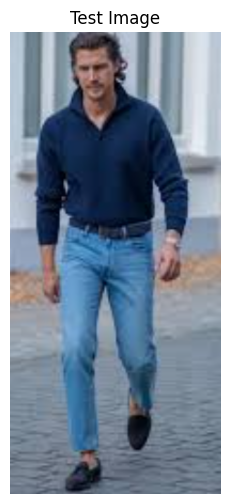

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Predictions:
What is the subcategory of this fashion item? Bottomwear
What type of article is this fashion item? news
What is the base color of this fashion item? blue
What season is this fashion item designed for? Fall
What is the intended usage of this fashion item? Casual




In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Import model architecture and processor


MODEL_PATH = "/content/Files"
TRAINED_MODEL_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"
IMAGE_PATH = "/content/Screenshot 2025-05-03 201130.png"
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_finetuned_model(base_model_path, trained_model_path, device):
    print(f"Loading base model from {base_model_path}")
    model, tokenizer = load_hf_model(base_model_path, device)
    if os.path.exists(trained_model_path):
        print(f"Loading fine-tuned weights from {trained_model_path}")
        state_dict = torch.load(trained_model_path, map_location=device)
        model.load_state_dict(state_dict, strict=False)
        print("Successfully loaded fine-tuned weights")
    else:
        print(f"Warning: Fine-tuned model not found at {trained_model_path}. Using base model.")
    model.eval()
    return model, tokenizer

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image_file_path, device):
    image = Image.open(image_file_path).convert("RGB")
    model_inputs = processor(text=[prompt], images=[image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_prediction(model, processor, image_path, prompt, max_tokens=50):
    model_inputs = get_model_inputs(processor, prompt, image_path, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]
    kv_cache = KVCache()
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_tokens):
            # Always pass pixel_values for this architecture!
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]
            next_token_logits = outputs["logits"][:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            token_id = next_token.item()
            generated_tokens.append(token_id)
            if token_id == stop_token:
                break
            input_ids = next_token
            attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)
            # pixel_values is always needed for this model
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

def run_inference_on_image(image_path, prompts=None):
    model, tokenizer = load_finetuned_model(MODEL_PATH, TRAINED_MODEL_PATH, device)
    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)
    if prompts is None:
        prompts = [
            "What is the subcategory of this fashion item?",
            "What type of article is this fashion item?",
            "What is the base color of this fashion item?",
            "What season is this fashion item designed for?",
            "What is the intended usage of this fashion item?"
        ]
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Test Image")
    plt.show()
    print("\nPredictions:")
    for prompt in prompts:
        prediction = generate_prediction(model, processor, image_path, prompt)
        print(f"{prompt} {prediction}")
    print("\n" + "="*50 + "\n")

if __name__ == "__main__":
    if not os.path.exists("/content/drive"):
        drive.mount('/content/drive')
    if os.path.exists(IMAGE_PATH):
        run_inference_on_image(IMAGE_PATH)
    else:
        print(f"Image not found at {IMAGE_PATH}. Please provide a valid image path.")

# inferencing based on live cam

Using device: cpu
Enter 'live' for webcam mode or 'file' to process a saved image: live
Loading base model from /content/Files
Loading fine-tuned weights from /content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt
Successfully loaded fine-tuned weights
Click 'Capture' to take a photo for fashion analysis


<IPython.core.display.Javascript object>

Photo saved as photo.jpg


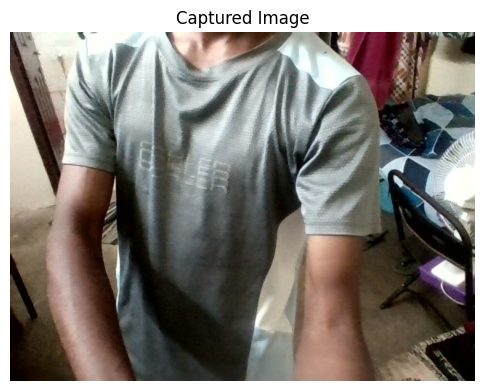

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Running inference on captured image...

Predictions:
What is the subcategory of this fashion item? Top
What type of article is this fashion item? shirt
What is the base color of this fashion item? Grey
What season is this fashion item designed for? summer
What is the intended usage of this fashion item? sports


Take another photo? (y/n): n


In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import os
import cv2
import numpy as np
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Import model architecture and processor (these need to be imported from your specific implementation)
# These were missing in your original code - you'll need to add the correct imports
# For example:
# from paligemma import load_hf_model, PaliGemmaProcessor, KVCache

MODEL_PATH = "/content/Files"
TRAINED_MODEL_PATH = "/content/drive/MyDrive/finetuned_paligemma/temp_train_model/model.pt"
OUTPUT_DIR = "/content/drive/MyDrive/finetuned_paligemma"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to capture images from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => {
            capture.onclick = resolve;
          });

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def load_finetuned_model(base_model_path, trained_model_path, device):
    print(f"Loading base model from {base_model_path}")
    model, tokenizer = load_hf_model(base_model_path, device)
    if os.path.exists(trained_model_path):
        print(f"Loading fine-tuned weights from {trained_model_path}")
        state_dict = torch.load(trained_model_path, map_location=device)
        model.load_state_dict(state_dict, strict=False)
        print("Successfully loaded fine-tuned weights")
    else:
        print(f"Warning: Fine-tuned model not found at {trained_model_path}. Using base model.")
    model.eval()
    return model, tokenizer

def move_inputs_to_device(model_inputs: dict, device: str):
    return {k: v.to(device) for k, v in model_inputs.items()}

def get_model_inputs(processor, prompt, image, device):
    """Process image (as numpy array or PIL Image) with the processor"""
    if isinstance(image, np.ndarray):
        # Convert OpenCV BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
    else:
        pil_image = image

    model_inputs = processor(text=[prompt], images=[pil_image])
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

def generate_prediction(model, processor, image, prompt, max_tokens=50):
    """Generate prediction for an image (can be PIL Image or numpy array)"""
    model_inputs = get_model_inputs(processor, prompt, image, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]
    kv_cache = KVCache()
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_tokens):
            # Always pass pixel_values for this architecture!
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                kv_cache=kv_cache,
            )
            kv_cache = outputs["kv_cache"]
            next_token_logits = outputs["logits"][:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            token_id = next_token.item()
            generated_tokens.append(token_id)
            if token_id == stop_token:
                break
            input_ids = next_token
            attention_mask = torch.cat([attention_mask, torch.ones((1, 1), device=device)], dim=-1)
            # pixel_values is always needed for this model
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return generated_text

def run_colab_webcam_inference():
    """Run inference with Colab's webcam interface"""
    # Load model and processor
    model, tokenizer = load_finetuned_model(MODEL_PATH, TRAINED_MODEL_PATH, device)
    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

    prompts = [
        "What is the subcategory of this fashion item?",
        "What type of article is this fashion item?",
        "What is the base color of this fashion item?",
        "What season is this fashion item designed for?",
        "What is the intended usage of this fashion item?"
    ]

    while True:
        print("Click 'Capture' to take a photo for fashion analysis")

        # Capture image from webcam
        try:
            filename = take_photo()
            print(f"Photo saved as {filename}")

            # Display the captured image
            img = Image.open(filename)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title("Captured Image")
            plt.show()

            # Process the captured image
            print("\nRunning inference on captured image...")
            print("\nPredictions:")
            for prompt in prompts:
                prediction = generate_prediction(model, processor, img, prompt)
                print(f"{prompt} {prediction}")
            print("\n" + "="*50 + "\n")

            # Ask if user wants to continue
            continue_capture = input("Take another photo? (y/n): ").strip().lower()
            if continue_capture != 'y':
                break

        except Exception as e:
            print(f"Error capturing or processing image: {e}")
            break

def run_inference_on_file(image_path, prompts=None):
    """Run inference on a file (keeping this for backward compatibility)"""
    model, tokenizer = load_finetuned_model(MODEL_PATH, TRAINED_MODEL_PATH, device)
    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

    if prompts is None:
        prompts = [
            "What is the subcategory of this fashion item?",
            "What type of article is this fashion item?",
            "What is the base color of this fashion item?",
            "What season is this fashion item designed for?",
            "What is the intended usage of this fashion item?"
        ]

    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Test Image")
    plt.show()

    print("\nPredictions:")
    for prompt in prompts:
        prediction = generate_prediction(model, processor, img, prompt)
        print(f"{prompt} {prediction}")
    print("\n" + "="*50 + "\n")

if __name__ == "__main__":
    # Mount Google Drive if needed
    if not os.path.exists("/content/drive"):
        drive.mount('/content/drive')

    # Ask user whether to use webcam or file
    mode = input("Enter 'live' for webcam mode or 'file' to process a saved image: ").strip().lower()

    if mode == 'live':
        run_colab_webcam_inference()
    else:
        image_path = input("Enter the path to the image file: ")
        if os.path.exists(image_path):
            run_inference_on_file(image_path)
        else:
            print(f"Image not found at {image_path}. Please provide a valid image path.")